## Imports and Data

In [1]:
#All the imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import collections
from collections import Counter, OrderedDict



In [2]:
##Read the data

train_data_r = pd.read_csv("https://raw.githubusercontent.com/sushanthreddyC/Aspect-Based-Sentiment-Analysis/main/data/Restaurants_Train_v2.csv", encoding='UTF-8')
train_data_lp = pd.read_csv("https://raw.githubusercontent.com/sushanthreddyC/Aspect-Based-Sentiment-Analysis/main/data/Laptop_Train_v2.csv", encoding='UTF-8')

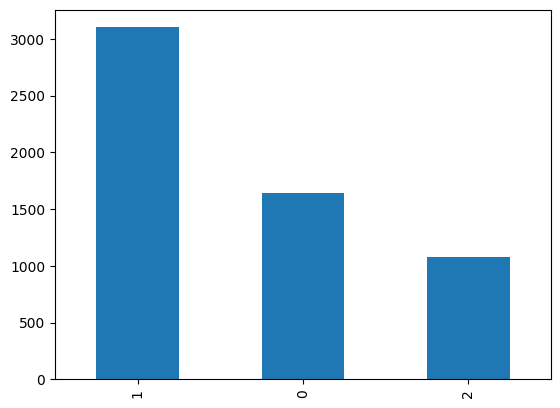

In [3]:
## Perform data cleaning

def data_cleaning(lp_train,rst_train):
  lp_train = lp_train.drop(columns=['from','to','id'])
  rst_train = rst_train.drop(columns=['from','to','id'])
  train_data =pd.concat([rst_train, lp_train])
  train_data.drop(train_data[train_data.polarity == 'conflict'].index, inplace= True)
  train_data['polarity'][train_data['polarity']=='negative'] = 0
  train_data['polarity'][train_data['polarity']=='positive'] = 1
  train_data['polarity'][train_data['polarity']=='neutral']  = 2
  train_data.polarity.value_counts().plot(kind ='bar')
  train_data["polarity"] = pd.to_numeric(train_data["polarity"],errors='coerce')
  X_train, X_test, y_train, y_test = train_test_split(train_data,train_data['polarity'],stratify=train_data['polarity'], test_size=0.2, random_state=1)

  l = 0
  for i in range(len(train_data)):
    l = max(l, len(train_data['Sentence'].iloc[i]))
  return X_train, X_test, y_train, y_test, l


X_train, X_test, y_train, y_test, max_len = data_cleaning(train_data_lp, train_data_r)


In [4]:
X_test.head()


,Sentence,Aspect Term,polarity
130,The strong scents coming from the left and rig...,scents,0
1725,"We ate out in the back patio, which is worth i...",music,1
502,"From the build quality to the performance, eve...",build quality,0
504,I love the dock where I can simply drop a file...,dock,1
1109,The first full charge of this battery got me o...,battery,0


(array([ 597., 1787., 1133.,  721.,  264.,   92.,   20.,   24.,   13.,
           3.]),
 array([ 1. ,  8.6, 16.2, 23.8, 31.4, 39. , 46.6, 54.2, 61.8, 69.4, 77. ]),
 <BarContainer object of 10 artists>)

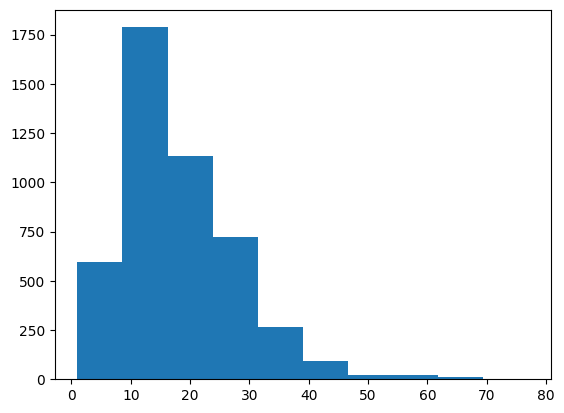

In [5]:
l = []
for i in list(X_train['Sentence']):
  l.append(len(i.split(' ')))
plt.hist(l)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

In [7]:
tokenizer = layers.TextVectorization(max_tokens=10000, output_sequence_length=35)

In [8]:
ex = list(X_train['Sentence'])
tokenizer.adapt(ex)


In [9]:
tokenizer(ex[4])

<tf.Tensor: shape=(35,), dtype=int64, numpy=
array([  32,  777,   32,   18, 4905, 4670,  320, 4468,   42,    2,  557,
          4,  325, 1854,    5, 4021,  105,   46,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])>

In [10]:
train_data = tf.data.Dataset.from_tensor_slices((ex, list(X_train['polarity']))).batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
valid_data = tf.data.Dataset.from_tensor_slices((list(X_test['Sentence']), list(X_test['polarity']))).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
run = False
if run:
  max_number = 0
  min_number = 1000000

  for i in ex:
    op = tokenizer(i)
    max_number = max(max(op), max_number)
    min_number = min(min(op), min_number)

  max_number, min_number

## Bi-LSTM

In [46]:
inputs = layers.Input(shape=(1,), dtype=tf.string, name='Sentence Input Layer')
tokens = tokenizer(inputs)
print(tokens.shape)
embeddings  = layers.Embedding(input_dim=6000, output_dim=128, name='Embedding_Layer')(tokens)
print(embeddings.shape)
lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True, name='LSTM'), name="Bi-Directional-1")(embeddings)
lstm2 = layers.Bidirectional(layers.LSTM(64, name='LSTM'), name='Bi-Directional-2')(lstm)
print(lstm.shape)
outputs = layers.Dense(3, activation='softmax', name='Output_Layer')(lstm2)

model = tf.keras.Model(inputs, outputs)


model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)
model.summary()

(None, 35)
(None, 35, 128)
(None, 35, 128)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Sentence Input Layer (Input  [(None, 1)]              0         
 Layer)                                                          
                                                                 
 text_vectorization (TextVec  (None, 35)               0         
 torization)                                                     
                                                                 
 Embedding_Layer (Embedding)  (None, 35, 128)          768000    
                                                                 
 Bi-Directional-1 (Bidirecti  (None, 35, 128)          98816     
 onal)                                                           
                                                                 
 Bi-Directional-2 (Bidirecti  (None, 128)              98816     
 onal)         

In [14]:
history = model.fit(
  train_data, epochs=5, verbose=1, validation_data=valid_data
)

Epoch 1/5
146/146 [==============================] - 39s 146ms/step - loss: 0.8577 - accuracy: 0.6115 - val_loss: 0.7251 - val_accuracy: 0.6856
Epoch 2/5
146/146 [==============================] - 2s 14ms/step - loss: 0.5837 - accuracy: 0.7643 - val_loss: 0.7073 - val_accuracy: 0.7148
Epoch 3/5
146/146 [==============================] - 2s 14ms/step - loss: 0.4429 - accuracy: 0.8343 - val_loss: 0.7403 - val_accuracy: 0.7285
Epoch 4/5
146/146 [==============================] - 2s 14ms/step - loss: 0.3700 - accuracy: 0.8631 - val_loss: 0.8078 - val_accuracy: 0.7242
Epoch 5/5
146/146 [==============================] - 3s 19ms/step - loss: 0.3351 - accuracy: 0.8715 - val_loss: 0.8732 - val_accuracy: 0.7208


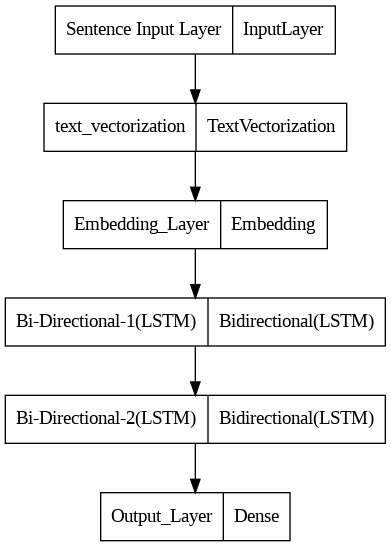

In [47]:
from tensorflow.keras.utils import plot_model

plot_model(model)

<Axes: >

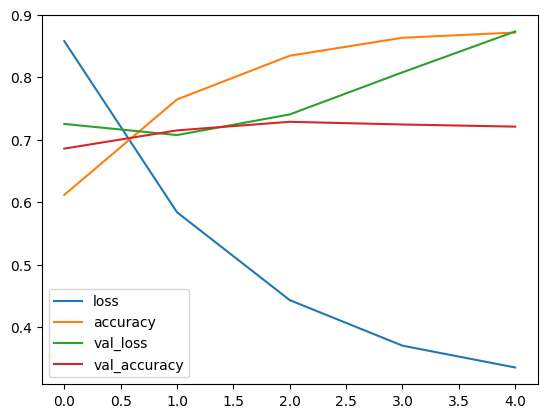

In [16]:
pd.DataFrame(history.history).plot()


## Multihead-Attention

In [17]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
tokens = tokenizer(inputs)

embeddings  = layers.Embedding(input_dim=6000, output_dim=128)(tokens)

ma_values = layers.MultiHeadAttention(num_heads=4, key_dim=32, value_dim=32, dropout=0.2)(embeddings, embeddings, embeddings)
dense = layers.Dense(64)(ma_values)
lstm = layers.Bidirectional(layers.LSTM(32))(dense)

outputs = layers.Dense(3, activation='softmax')(lstm)

ma_model = tf.keras.Model(inputs, outputs)


ma_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)
ma_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 35)          0           ['input_2[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 128)      768000      ['text_vectorization[1][0]']     
                                                                                                  
 multi_head_attention (MultiHea  (None, 35, 128)     66048       ['embedding_1[0][0]',      

In [18]:
history_ma = ma_model.fit(
  train_data, epochs=5, verbose=1, validation_data=valid_data
)

Epoch 1/5
146/146 [==============================] - 21s 103ms/step - loss: 0.8950 - accuracy: 0.5900 - val_loss: 0.7862 - val_accuracy: 0.6615
Epoch 2/5
146/146 [==============================] - 2s 17ms/step - loss: 0.6680 - accuracy: 0.7129 - val_loss: 0.7630 - val_accuracy: 0.6761
Epoch 3/5
146/146 [==============================] - 2s 13ms/step - loss: 0.5567 - accuracy: 0.7770 - val_loss: 0.7784 - val_accuracy: 0.7010
Epoch 4/5
146/146 [==============================] - 2s 12ms/step - loss: 0.4575 - accuracy: 0.8272 - val_loss: 0.8472 - val_accuracy: 0.7285
Epoch 5/5
146/146 [==============================] - 2s 13ms/step - loss: 0.3928 - accuracy: 0.8509 - val_loss: 0.9736 - val_accuracy: 0.7156


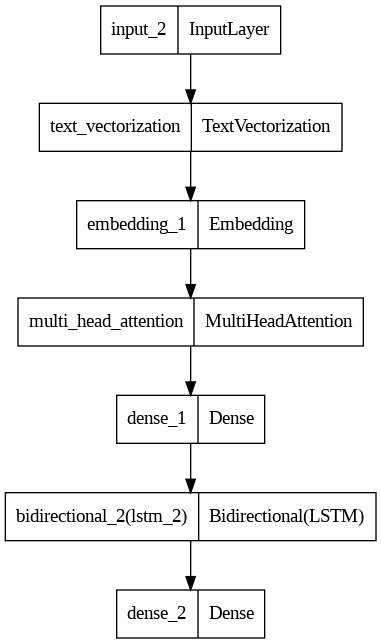

In [19]:
plot_model(ma_model)

<Axes: >

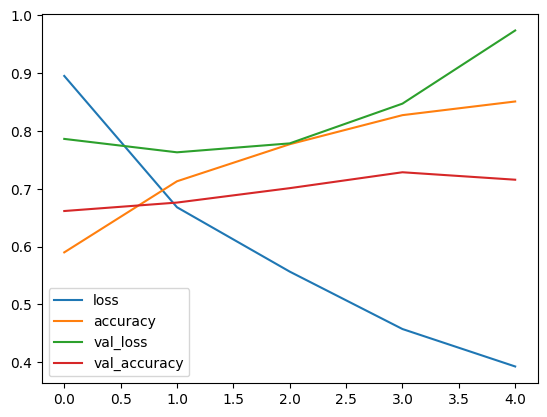

In [20]:
pd.DataFrame(history_ma.history).plot()

## Aspect_Embedded Attention

(array([4.278e+03, 3.360e+02, 3.100e+01, 2.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

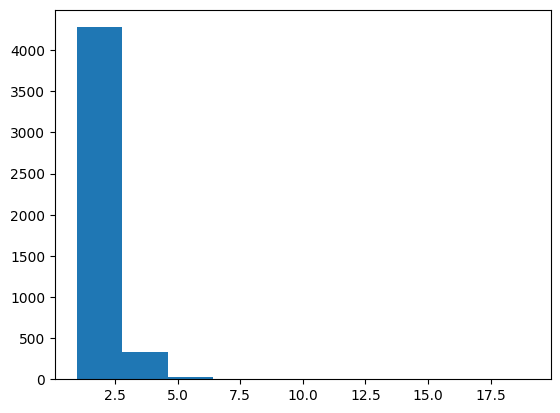

In [21]:
train_aspects = list(X_train['Aspect Term'])

l = []
for i in train_aspects:
  l.append(len(i.split(' ')))

plt.hist(l)

In [22]:
aspect_tokenizer = layers.TextVectorization(max_tokens=10000, output_sequence_length=5)
aspect_tokenizer.adapt(train_aspects)

In [24]:
if run:
  max_number = 0
  min_number = 1000000

  for i in train_aspects:
    op = aspect_tokenizer(i)
    max_number = max(max(op), max_number)
    min_number = min(min(op), min_number)

  max_number, min_number

In [25]:
train_data_ae = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(((ex, train_aspects),  list(X_train['polarity'])))).batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
valid_data_ae = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(((list(X_test['Sentence']), list(X_test['Aspect Term'])),  list(X_test['polarity'])))).batch(32).prefetch(tf.data.AUTOTUNE)

In [36]:
text_ip = layers.Input(shape=(1,), dtype='string')
aspect_ip = layers.Input(shape=(1,), dtype='string')

text_tokens = tokenizer(text_ip)
text_embeddings = layers.Embedding(input_dim=6000, output_dim=128)(text_tokens)
attention1 = layers.MultiHeadAttention(num_heads=4, key_dim=32, value_dim=32, dropout=0.2)(text_embeddings, text_embeddings, text_embeddings)
lstm1 = layers.LSTM(64)(attention1)
text_op = layers.Dense(64)(lstm1)

text_model = tf.keras.Model(text_ip, text_op)

aspect_tokens = aspect_tokenizer(aspect_ip)
aspect_embeddings = layers.Embedding(input_dim=2000, output_dim=64)(aspect_tokens)
attention2 = layers.MultiHeadAttention(num_heads=4, key_dim=16, value_dim=16, dropout=0.2)(aspect_embeddings, aspect_embeddings, aspect_embeddings)
lstm2 = layers.LSTM(64)(attention2)
aspect_op = layers.Dense(64)(lstm2)

aspect_model = tf.keras.Model(aspect_ip, aspect_op)


concatenate = layers.concatenate([text_model.output, aspect_model.output])

final_op = layers.Dense(3, activation='softmax')(concatenate)

embed_model = tf.keras.Model([text_model.input, aspect_model.input], final_op)

embed_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)


embed_model.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 35)          0           ['input_7[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 5)           0           ['input_8[0][0]']         

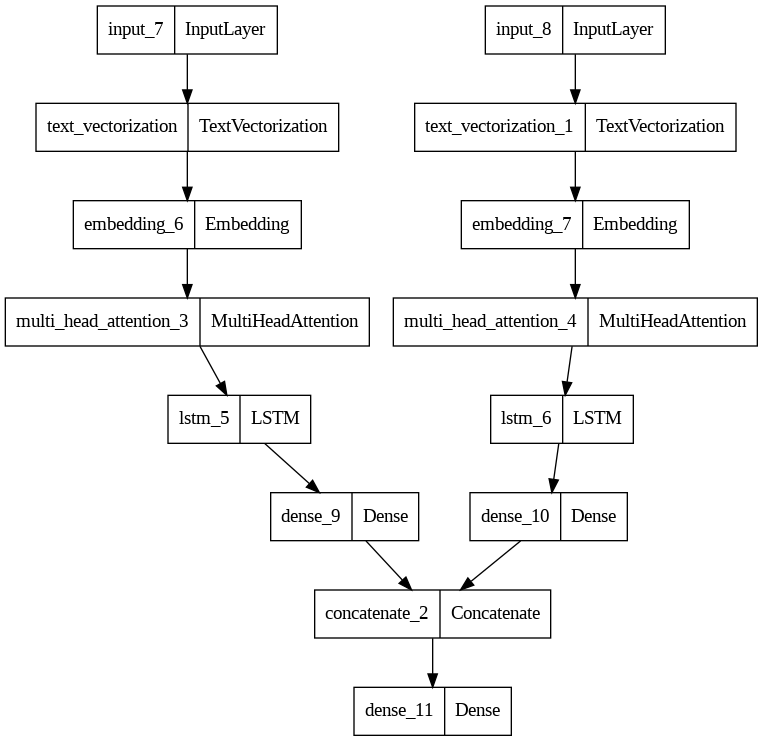

In [37]:
plot_model(embed_model)

In [38]:
history_em = embed_model.fit(
  train_data_ae, epochs=5, verbose=1, validation_data=valid_data_ae
)

Epoch 1/5
146/146 [==============================] - 27s 131ms/step - loss: 0.8921 - accuracy: 0.5935 - val_loss: 0.7752 - val_accuracy: 0.6632
Epoch 2/5
146/146 [==============================] - 2s 14ms/step - loss: 0.6398 - accuracy: 0.7310 - val_loss: 0.7603 - val_accuracy: 0.6942
Epoch 3/5
146/146 [==============================] - 3s 20ms/step - loss: 0.5165 - accuracy: 0.7894 - val_loss: 0.8034 - val_accuracy: 0.6881
Epoch 4/5
146/146 [==============================] - 3s 19ms/step - loss: 0.4350 - accuracy: 0.8311 - val_loss: 0.8718 - val_accuracy: 0.6924
Epoch 5/5
146/146 [==============================] - 3s 22ms/step - loss: 0.3756 - accuracy: 0.8554 - val_loss: 1.0303 - val_accuracy: 0.6976


<Axes: >

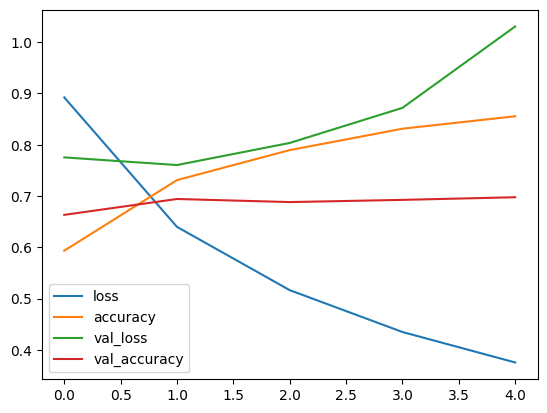

In [39]:
pd.DataFrame(history_em.history).plot()